In [94]:
import gzip
from espsim import GetEspSim
from rdkit import Chem
import pandas as pd
import ast
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.metrics import mean_absolute_error

In [65]:
# Run EON on the aligned molecules (each reference molecules, e.g. data_benchmark_2/ref_0.sdf.gz 
# has 351 aligned reference molecules, e.g. data_benchmark_2/prb_aligned_to_ref_0.sdf.gz)
# and save scores into a dictionary called eons (see ESP-Sim scores below for formatting).
# Due to license issues, we cannot provide the scores.

#eons=

In [66]:
charges=pd.read_csv('data_benchmark_2/charges.csv')

In [100]:
#To produce ESP-Sim scores:
ss={}
for name in ['AM1BCC','MMFF','Gasteiger']:
    ss[name]=[]
    data=charges[charges['Partial Charge distribution']==name]
    for idx in range(99):
        data2=data[data['Ref Idx']==idx]
        refCharge=ast.literal_eval(data2['Ref Charge'].values[0])
        prbCharges=[ast.literal_eval(x) for x in data2['Prb Charge'].values]
        
        if not False in [x==0 for x in refCharge]:
            continue
        
        inf = gzip.open('data_benchmark_2/prb_aligned_to_ref_'+str(idx)+'.sdf.gz')
        gzsuppl= Chem.ForwardSDMolSupplier(inf,removeHs=False)
        test_prb = [mol for mol in gzsuppl]
        inf.close()
    
        inf = gzip.open('data_benchmark_2/ref_'+str(idx)+'.sdf.gz')
        gzsuppl= Chem.ForwardSDMolSupplier(inf,removeHs=False)
        test_ref = [mol for mol in gzsuppl][0]
        inf.close()
        
        s=[]
        for i in range(len(test_prb)):
            prbCharge=ast.literal_eval(data2['Prb Charge'].values[i])
            if not False in [x==0 for x in prbCharge]:
                continue
            s.append(GetEspSim(test_prb[i],test_ref,prbCharge=prbCharges[i],refCharge=refCharge,renormalize=False,metric='tanimoto'))
        if len(s)>0:
            ss[name].append(s)

In [101]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [104]:
p={}
for name in ['AM1BCC','MMFF','Gasteiger']:
    p = [stats.spearmanr(ss[name][i],eons[name][i])[0] for i in range(len(ss[name]))]
    e = [mean_absolute_error(ss[name][i],eons[name][i]) for i in range(len(ss[name]))]
    print(name,"corr:",np.mean(p),"mae:",np.mean(e))

AM1BCC corr: 0.7518443414903099 mae: 0.10706774090575938
MMFF corr: 0.8107417068347225 mae: 0.08506555140440542
Gasteiger corr: 0.8276710157986443 mae: 0.11748545265383435


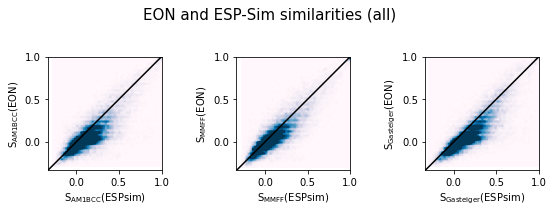

In [88]:
fig, axs = plt.subplots(1,3, figsize=(8,3))

for i,name in enumerate(['AM1BCC','MMFF','Gasteiger']):
    axs[i].set_xlim([-1/3,1])
    axs[i].set_ylim([-1/3,1])
    axs[i].set_ylabel('$\mathregular{S_{'+name+'}}$(EON)')
    axs[i].set_xlabel('$\mathregular{S_{'+name+'}}$(ESPsim)')
    x=flatten(ss[name])
    y=flatten(eons[name])
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    axs[i].plot([-1/3,1],[-1/3,1],color='black')
    
    axs[i].imshow(heatmap.T,  extent=extent, origin='lower', cmap=plt.cm.PuBu, vmin=0, vmax=100) #
    
fig.suptitle("EON and ESP-Sim similarities",fontsize=15)
fig.tight_layout()


plt.show()